# Paso 1. Configuración del entorno

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Paso 2. Dataset QSAR Biodegradation

In [2]:
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = fetch_openml(data_id=1494, as_frame=True)
df = data.frame

print("Shape:", df.shape)
print("Columnas:", df.columns.tolist())
print("Tipos:\n", df.dtypes)
print("Valores únicos en 'class':", df['Class'].unique())

Shape: (1055, 42)
Columnas: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'Class']
Tipos:
 V1        float64
V2        float64
V3          int64
V4          int64
V5          int64
V6          int64
V7          int64
V8        float64
V9          int64
V10         int64
V11         int64
V12       float64
V13       float64
V14       float64
V15       float64
V16         int64
V17       float64
V18       float64
V19         int64
V20         int64
V21         int64
V22       float64
V23         int64
V24         int64
V25         int64
V26         int64
V27       float64
V28       float64
V29         int64
V30       float64
V31       float64
V32         int64
V33         int64
V34         int64
V35         int64
V36       float64
V37       float64
V38       

In [3]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V33,V34,V35,V36,V37,V38,V39,V40,V41,Class
0,3.919,2.6909,0,0,0,0,0,31.4,2,0,...,0,0,0,2.949,1.591,0,7.253,0,0,2
1,4.170,2.1144,0,0,0,0,0,30.8,1,1,...,0,0,0,3.315,1.967,0,7.257,0,0,2
2,3.932,3.2512,0,0,0,0,0,26.7,2,4,...,0,0,1,3.076,2.417,0,7.601,0,0,2
3,3.000,2.7098,0,0,0,0,0,20.0,0,2,...,0,0,1,3.046,5.000,0,6.690,0,0,2
4,4.236,3.3944,0,0,0,0,0,29.4,2,4,...,0,0,0,3.351,2.405,0,8.003,0,0,2


In [4]:
df['Class'] = df['Class'].map({'2': 1, '1': 0})

X = df.drop(columns=['Class'])

y = df['Class'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_train.to_numpy().astype("int32")
y_test = y_test.to_numpy().astype("int32")

# Paso 3. Creación del experimento en MLflow

In [5]:
import mlflow

mlflow.set_experiment("clasificacion_binaria")

<Experiment: artifact_location='file:///C:/Users/Patecnologicos/Documents/UNIVERSIDAD/12vo%20semestre/MLOps/Laboratorios/Laboratorio%20MLFLOW%20TRACKING%20%28Semana%208%29/mlruns/427655561740034218', creation_time=1762028691466, experiment_id='427655561740034218', last_update_time=1762028691466, lifecycle_stage='active', name='clasificacion_binaria', tags={'mlflow.experimentKind': 'custom_model_development'}>

# Paso 4. Modelo 1 – Regresión Logística (Scikit-learn)

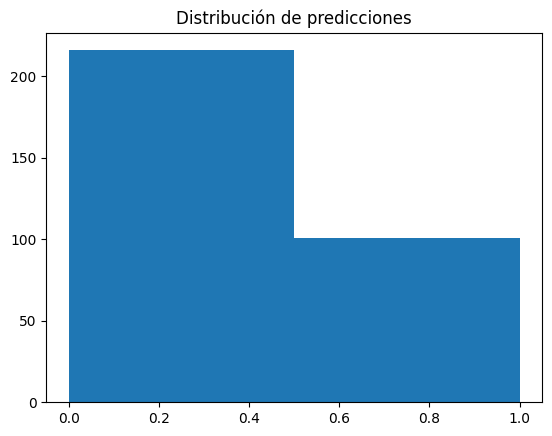

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Hiperparámetros
C = 1.0
max_iter = 500
solver = "liblinear"
penalty = "l2"

with mlflow.start_run(run_name="logistic_regression_manual") as run:

    model = LogisticRegression(C=C, max_iter=max_iter, solver=solver, penalty=penalty)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    mlflow.log_param("C", C)
    mlflow.log_param("max_iter", max_iter)
    mlflow.log_param("solver", solver)
    mlflow.log_param("penalty", penalty)


    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)

    mlflow.set_tags({
        "author": "Grupo_MLOps",
        "purpose": "Clasificación binaria con dataset qsar-biodeg"
    })

    plt.figure()
    plt.hist(y_pred, bins=2)
    plt.title("Distribución de predicciones")
    plt.savefig("predicciones.png")
    mlflow.log_artifact("predicciones.png")

    mlflow.log_text("Modelo de regresión logística entrenado en dataset qsar-biodeg", "notas.txt")

    mlflow.log_dict({"dataset": "qsar-biodeg", "target": "Class"}, "config.json")

# Paso 5. Modelo 2 – Red Neuronal (TensorFlow/Keras)

In [7]:
import tensorflow as tf
import mlflow.tensorflow

# Activar autologging
mlflow.tensorflow.autolog()

model_nn = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])


model_nn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [8]:
with mlflow.start_run(run_name="keras_autologging"):
    history = model_nn.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=20,
        batch_size=32,
        verbose=0
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


2025/11/01 17:12:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


# Paso 6. Comparación de Experimentos

# Paso 7. Interpretación con Ollama